In [23]:
%matplotlib inline
from dolfin import *
from mshr import *
import numpy as np
from scipy.special import kn
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.tri as tri

set_log_active(False)
dolfin.parameters.reorder_dofs_serial = False

In [29]:
domain = Rectangle(Point(-1,-1), Point(1,1)) - Circle(Point(0,0),0.5)
MESH = generate_mesh(domain, 20)
n = MESH.num_vertices()
dd = MESH.geometry().dim()

MESH_cord = MESH.coordinates().reshape((n,d))
triangles = np.asarray([cell.entities(0) for cell in cells(MESH)])
triangulation = tri.Triangulation(MESH_cord[:,0], MESH_cord[:,1],triangles)

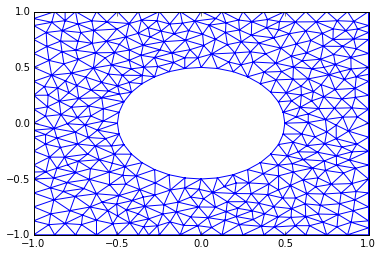

In [30]:
plt.figure()
plt.triplot(triangulation);

In [ ]:
#nn = mesh.num_vertices()
#ddd = mesh.geometry().dim()
#mesh_coord = mesh.corrdinates().reshape((nn,ddd))
#TRIangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
#TRIangulation = tri.Triangulation(mesh_coord[:,0], mesh_coord[:,1],TRIangles)

In [31]:
thetaS = 0.2

d = 2
q = 2
#THIS SECTION IS FOR MAKING THE MESH

r1 = 1 #radius of cylinder
r2 = 10 #radius of bounding circle
nr = 30 #number of radial divisions
nt = 50 #number of theta divisions
mesh = RectangleMesh(Point(r1, 0), Point(r2, 1), nr, nt, "crossed")



x = mesh.coordinates()[:,0]
y = mesh.coordinates()[:,1]

def denser(x,y,q):
	return [r1 + (r2-r1)*((x-r1)/(r2-r1))**q, y]

x_bar, y_bar = denser(x, y, q)
xy_bar_coor = np.array([x_bar,y_bar]).transpose()
mesh.coordinates()[:] = xy_bar_coor

def cylinder(r, s, Theta):
	return [r*np.cos(Theta*s), r*np.sin(Theta*s)]

x_hat, y_hat = cylinder(x_bar, y_bar,2*np.pi)
xy_hat_coor = np.array([x_hat,y_hat]).transpose()
mesh.coordinates()[:] = xy_hat_coor

AttributeError: 'RectangleMesh' object has no attribute 'corrdinates'

In [14]:
#THIS SECTION IS FOR MARKING BOUNDARIES OF THE MESH
class outer_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-2
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - r2) < tol

class inner_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-2
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - r1) < tol

class half_circleX(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-2
		return on_boundary and abs(x[1]) < tol

class half_circleY(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-2
		return on_boundary and abs(x[0]) < tol

outerradius = outer_boundary()
innerradius = inner_boundary()
half_circleX = half_circleX()
half_circleY = half_circleY()

boundaries = FacetFunction("size_t", mesh)

boundaries.set_all(0)
innerradius.mark(boundaries,1)
outerradius.mark(boundaries,2)
half_circleX.mark(boundaries,3)
half_circleY.mark(boundaries,4)

In [15]:
#This section defines the finite element basis functions, applies boundary conditions,
#defines and solves the problem
V = FunctionSpace(mesh,'Lagrange',1)
nx = TrialFunction(V)
ny = TrialFunction(V)
v1 = TestFunction(V)
v2 = TestFunction(V)

#~ gx = Expression('-x[1]*sin(ThetaInner)/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = thetaS) 
#~ gy = Expression('x[0]*sin(ThetaInner)/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = thetaS)

gx = Expression('-x[1]*ThetaInner/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = thetaS) 
gy = Expression('x[0]*ThetaInner/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = thetaS)

#For nx
bcs1 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gx, boundaries, 1), DirichletBC(V, 0, boundaries, 3)]
#for ny
bcs2 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gy, boundaries, 1), DirichletBC(V, 0, boundaries, 4)]

DEBUG:FFC:Reusing form from cache.


In [16]:
f = Constant(0)
g = Constant(d**-2)

a1 = (inner(nabla_grad(nx), nabla_grad(v1)) + g*(inner(nx,v1)))*dx
a2 = (inner(nabla_grad(ny), nabla_grad(v2)) + g*(inner(ny,v2)))*dx
L1 = f*v1*dx
L2 = f*v2*dx
nx = Function(V)
ny = Function(V)
solve(a1 == L1, nx, bcs1)
solve(a2 == L2, ny, bcs2)

V_d = VectorFunctionSpace(mesh,'Lagrange',1)
w1 = TrialFunction(V_d)
w2 = TrialFunction(V_d)
q1 = TestFunction(V_d)
q2 = TestFunction(V_d)

a3 = inner(w1,q1)*dx
a4 = inner(w2,q2)*dx
L3 = inner(grad(nx),q1)*dx
L4 = inner(grad(ny),q2)*dx
grad_nx = Function(V_d)
grad_ny = Function(V_d)
solve(a3 == L3, grad_nx)
solve(a4 == L4, grad_ny)

dxnx, dynx = grad_nx.split(deepcopy=True)
dxny, dyny = grad_ny.split(deepcopy=True)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


In [17]:
class int_radius(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-4
        r = sqrt(x[0]*x[0] + x[1]*x[1])
        return ((r - r1) > tol)  

int_radius = int_radius()
cell_markers = CellFunction("uint", mesh)
cell_markers.set_all(0)
int_radius.mark(cell_markers,5)
dx1 = Measure("dx", domain=mesh, subdomain_data=cell_markers)

In [18]:
quad = (pow(d,2)/2)*(pow(dxnx,2) + pow(dynx,2) + pow(dxny,2) + pow(dyny,2))
surf = pow(d,2)*(dxnx*dyny - dxny*dynx)
field = (pow(1,2)*(pow(nx,2) + pow(ny,2)) - pow(1,2))/2

Equad = assemble(quad*dx1(5))
Esurf = assemble(surf*dx1(5))
field_energy = assemble(field*dx1(5))

fel = quad+surf+field
Ftot = Equad+Esurf+field_energy

print("Quadratic energy %0.5f" % Equad)
print("Surface energy %0.5f" % Esurf)
print("E-field energy %0.5f" % field_energy)
print("Total energy %0.5f" % (field_energy + Esurf + Equad))

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Quadratic energy 0.53449
Surface energy -0.49217
E-field energy -154.98096
Total energy -154.93864


In [22]:
cmap = plt.cm.jet
plt.figure()
eff = np.asarray([fel(point) for point in mesh_co])
plot(fel, title='f', mode='color', interactive=True)
plt.show();
#~ plot(nx, title='nx', mode='color', interactive=True)
#~ plot(ny, title='ny', mode='color', interactive=True)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


In [ ]:
codenx = '''
#include <math.h>
#include <boost/math/special_functions/bessel.hpp>
using boost::math::cyl_bessel_k;
using boost::math::cyl_neumann;

namespace dolfin {
	class MyFun : public Expression
	{
		double d, r1, thetaS;
		public:
			MyFun(): Expression() {};
		void eval(Array<double>& values, const Array<double>& x) const {
			double f1 = sqrt(x[0]*x[0] + x[1]*x[1])/d;
			double f2 = r1/d;
			values[0] = -thetaS*x[1]*cyl_bessel_k(1,f1)/(sqrt(x[0]*x[0] + x[1]*x[1])*cyl_bessel_k(1,f2));
		}

		void update(double _d, double _r1, double thetaS) {
			d = _d;
			r1 = _r1;
			thetaS = thetaS;
		}
	};
}'''

nx_analytic = Expression(codenx)

nx_error = errornorm(nx_analytic,nx)

print('nx error %e' %nx_error)

In [ ]:
#Here are the analytical solutions. These will be compared to the numerical solutions

def r(x,y):
	return np.sqrt(x**2 + y**2)

def Nx(x, y, d, r1, thetaS):
	return -(thetaS*y*kn(1, r(x,y)*d**-1)/(r(x,y)*kn(1, r1*d**-1)))

def Ny(x, y, d, r1, thetaS):
	return (thetaS*x*kn(1, r(x,y)*d**-1)/(r(x,y)*kn(1, r1*d**-1)))

def dx_nx(x, y, d, r1, thetaS):
	return (thetaS*x*y*(r(x,y)*kn(0, r(x,y)*d**-1) + 2*d*kn(1, r(x,y)*d**-1)))/(2*d*r(x,y)**3*kn(1, r1*d**-1))

def dy_nx(x, y, d, r1, thetaS):
	return (thetaS*((y**2/r(x,y))*kn(0, r(x,y)*d**-1) + 2*d*(y/r(x,y))**2*kn(1, r(x,y)*d**-1) - d*kn(1, r(x,y)*d**-1)))/(d*r(x,y)*kn(1, r1*d**-1))

def dx_ny(x, y, d, r1, thetaS):
	return -(thetaS*((x**2/r(x,y))*kn(0, r(x,y)*d**-1) + 2*d*(x/r(x,y))**2*kn(1, r(x,y)*d**-1) - d*kn(1, r(x,y)*d**-1)))/(d*r(x,y)*kn(1, r1*d**-1))

def dy_ny(x, y, d, r1, thetaS):
	return -(thetaS*x*y*(r(x,y)*kn(0, r(x,y)*d**-1) + 2*d*kn(1, r(x,y)*d**-1)))/(d*r(x,y)**3*kn(1, r1*d**-1))

In [ ]:
nx_array = nx.vector().array()
ny_array = ny.vector().array()
dxnx_array = dxnx.vector().array()
dynx_array = dynx.vector().array()
dxny_array = dxny.vector().array()
dyny_array = dyny.vector().array()

coor = mesh.coordinates()
num_vertices = mesh.num_vertices()

X, Y, R = [], [], []
nx_numerical, ny_numerical, nx_analytical, ny_analytical = [], [], [], []
dxnx_numerical, dynx_numerical, dxny_numerical, dyny_numerical = [], [], [], []
dxnx_analytical, dynx_analytical, dxny_analytical, dyny_analytical = [], [], [], []

phi = (np.pi/6)

for i in range(num_vertices):
	if ((phi >= 0) and (phi < (np.pi/4))):
		if abs(coor[i][1] - np.tan(phi)*coor[i][0]) < 5E-2:
			xi = coor[i][0]
			yi = coor[i][1]
			ri = np.sqrt((xi**2) + (yi**2))

			R.append(ri)
			X.append(xi)
			Y.append(yi)

			nx_numerical.append(nx_array[i])
			ny_numerical.append(ny_array[i])
			nx_analytical.append(Nx(xi, yi, d, r1, thetaS))
			ny_analytical.append(Ny(xi, yi, d, r1, thetaS))

			dxnx_numerical.append(dxnx_array[i])
			dynx_numerical.append(dynx_array[i])
			dxny_numerical.append(dxny_array[i])
			dyny_numerical.append(dyny_array[i])

			dxnx_analytical.append(dx_nx(xi, yi, d, r1, thetaS))
			dynx_analytical.append(dy_nx(xi, yi, d, r1, thetaS))
			dxny_analytical.append(dx_ny(xi, yi, d, r1, thetaS))
			dyny_analytical.append(dy_ny(xi, yi, d, r1, thetaS))
	elif (phi >= np.pi/4) and (phi <= np.pi/2):
		if abs(coor[i][0] - coor[i][1]/np.tan(phi)) < 5E-2:
			xi = coor[i][0]
			yi = coor[i][1]
			ri = np.sqrt((xi**2) + (yi**2))

			R.append(ri)
			X.append(xi)
			Y.append(yi)

			nx_numerical.append(nx_array[i])
			ny_numerical.append(ny_array[i])
			nx_analytical.append(Nx(xi, yi, d, r1, thetaS))
			ny_analytical.append(Ny(xi, yi, d, r1, thetaS))

			dxnx_numerical.append(dxnx_array[i])
			dynx_numerical.append(dynx_array[i])
			dxny_numerical.append(dxny_array[i])
			dyny_numerical.append(dyny_array[i])

			dxnx_analytical.append(dx_nx(xi, yi, d, r1, thetaS))
			dynx_analytical.append(dy_nx(xi, yi, d, r1, thetaS))
			dxny_analytical.append(dx_ny(xi, yi, d, r1, thetaS))
			dyny_analytical.append(dy_ny(xi, yi, d, r1, thetaS))
	else:
		break

In [ ]:
#~ plt.scatter(R,nx_numerical, color='red', label = 'Numerical')
#~ plt.scatter(R,nx_analytical, label = 'Analytical')
#~ plt.title("nx_numerical vs. nx_analytical")
#~ plt.legend();

In [ ]:
#~ plt.scatter(R,ny_numerical, color='red', label = 'Numerical')
#~ plt.scatter(R,ny_analytical, label = 'Analytical')
#~ plt.title("ny_numerical vs. ny_analytical")
#~ plt.legend();

In [ ]:
#~ plt.scatter(R,dxnx_numerical, color='red', label = 'Numerical')
#~ plt.scatter(R,dxnx_analytical, label = 'Analytical')
#~ plt.title("dxnx_numerical vs. dxnx_analytical")
#~ plt.legend();

In [ ]:
#~ plt.scatter(R,dynx_numerical, color='red', label = 'Numerical')
#~ plt.scatter(R,dynx_analytical, label = 'Analytical')
#~ plt.title("dynx_numerical vs. dynx_analytical")
#~ plt.legend();

In [ ]:
#~ plt.scatter(R,dxny_numerical, color='red', label = 'Numerical')
#~ plt.scatter(R,dxny_analytical, label = 'Analytical')
#~ plt.title("dxny_numerical vs. dxny_analytical")
#~ plt.legend();

In [ ]:
#~ plt.scatter(R,dyny_numerical, color='red', label = 'Numerical')
#~ plt.scatter(R,dyny_analytical, label = 'Analytical')
#~ plt.title("dyny_numerical vs. dyny_analytical")
#~ plt.legend();